In [25]:
import matplotlib.pyplot as plt
import numpy as np
from cigar import Cigar
import pandas as pd

### Задание 0

In [3]:
! minimap2 -d reference.mmi reference.fasta

[M::mm_idx_gen::0.161*1.06] collected minimizers
[M::mm_idx_gen::0.183*1.30] sorted minimizers
[M::main::0.283*1.19] loaded/built the index for 1 target sequence(s)
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.294*1.18] distinct minimizers: 838533 (98.18% are singletons); average occurrences: 1.034; average spacing: 5.352
[M::main] Version: 2.17-r941
[M::main] CMD: minimap2 -d reference.mmi reference.fasta
[M::main] Real time: 0.307 sec; CPU: 0.360 sec; Peak RSS: 0.065 GB


In [5]:
! minimap2 -ax map-pb reference.mmi pacbio_40x.fq > alignment_pacbio.sam

[WARNING] Indexing parameters (-k, -w or -H) overridden by parameters used in the prebuilt index.
[M::main::0.085*1.05] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.097*1.04] mid_occ = 11
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.106*1.03] distinct minimizers: 838533 (98.18% are singletons); average occurrences: 1.034; average spacing: 5.352
[M::worker_pipeline::34.673*2.85] mapped 41447 sequences
[M::main] Version: 2.17-r941
[M::main] CMD: minimap2 -ax map-pb reference.mmi pacbio_40x.fq
[M::main] Real time: 34.697 sec; CPU: 98.814 sec; Peak RSS: 1.985 GB


In [6]:
! minimap2 -ax map-ont reference.mmi SRR6334890.fastq > alignment_ont.sam

[M::main::0.091*1.00] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.104*1.00] mid_occ = 11
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.115*1.00] distinct minimizers: 838533 (98.18% are singletons); average occurrences: 1.034; average spacing: 5.352
[M::worker_pipeline::13.584*2.78] mapped 30810 sequences
[M::main] Version: 2.17-r941
[M::main] CMD: minimap2 -ax map-ont reference.mmi SRR6334890.fastq
[M::main] Real time: 13.600 sec; CPU: 37.802 sec; Peak RSS: 0.921 GB


In [7]:
! samtools view -S -b alignment_pacbio.sam > alignment_pacbio.bam

In [8]:
! samtools view -S -b alignment_ont.sam > alignment_ont.bam

In [9]:
! samtools flagstat alignment_pacbio.bam

49743 + 0 in total (QC-passed reads + QC-failed reads)
1528 + 0 secondary
6768 + 0 supplementary
0 + 0 duplicates
48434 + 0 mapped (97.37% : N/A)
0 + 0 paired in sequencing
0 + 0 read1
0 + 0 read2
0 + 0 properly paired (N/A : N/A)
0 + 0 with itself and mate mapped
0 + 0 singletons (N/A : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


Видим, что процент приложившихся ридов Pacbio равен 97.37.

In [10]:
! samtools flagstat alignment_ont.bam

32103 + 0 in total (QC-passed reads + QC-failed reads)
1072 + 0 secondary
221 + 0 supplementary
0 + 0 duplicates
29565 + 0 mapped (92.09% : N/A)
0 + 0 paired in sequencing
0 + 0 read1
0 + 0 read2
0 + 0 properly paired (N/A : N/A)
0 + 0 with itself and mate mapped
0 + 0 singletons (N/A : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


Видим, что процент приложившихся ридов Oxford Nanopores равен 92.09.

### Задание 1

#### Покрытие генома

In [11]:
def get_coverage(sam_file_name, ref_file_name):    
    sam_file = open(sam_file_name, 'r')
    ref_file = open(ref_file_name, 'r')
    sam_file.readline()
    sam_file.readline()
    ref_length = 0
    ref_file.readline()
    for line in ref_file:
        ref_length += len(line)
    per_base_coverage = np.zeros(ref_length)
    for line in sam_file:
        line = line.strip().split()
        start = int(line[3])
        read_length = len(line[9])
        stop = min(start + read_length - 1, ref_length)
        per_base_coverage[start:stop] = per_base_coverage[start:stop] + 1
    ref_file.close()
    sam_file.close()
    return per_base_coverage

Риды Pacbio

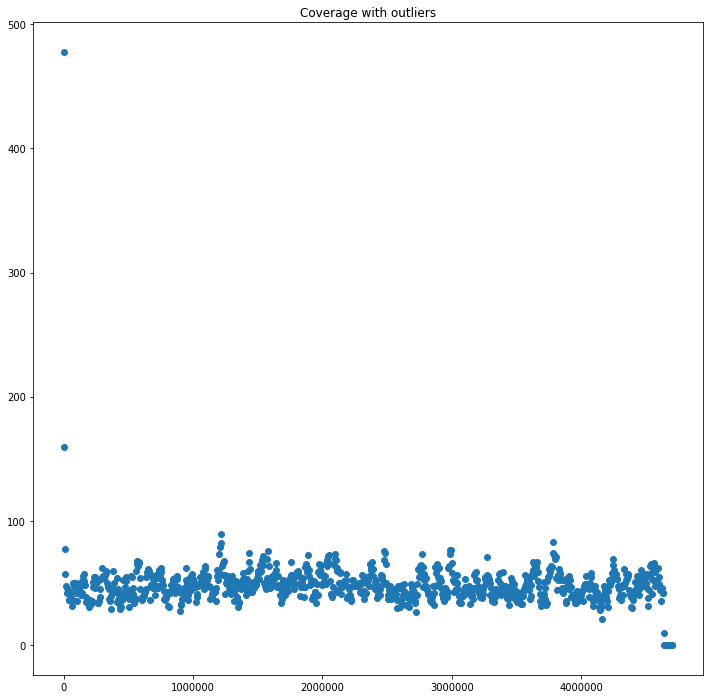

In [14]:
# покрытие с выбросами
per_base_coverage = get_coverage('alignment_pacbio.sam', 'reference.fasta')
n = len(per_base_coverage)
M = []
N = []
for i in range(0, n, 5000):
    M.append(i)
    N.append(sum(per_base_coverage[i:(i+5000)]) / 5000)
plt.figure(figsize=(12, 12))
plt.title('Coverage with outliers')
plt.scatter(M, N)

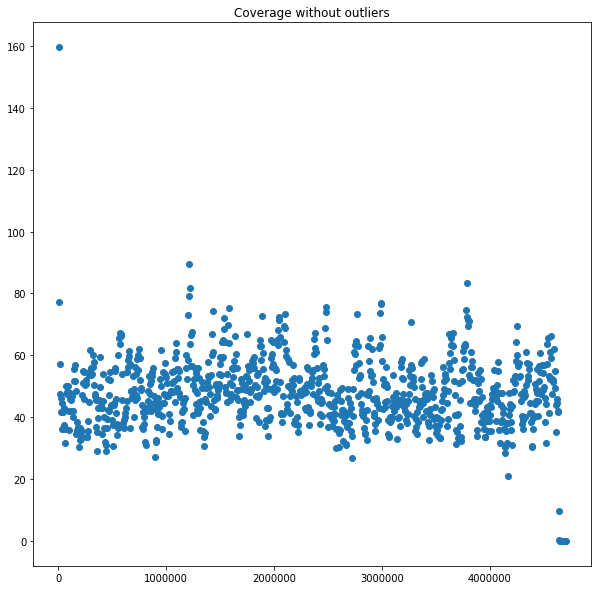

In [16]:
# покрытие без выбросов
N = np.asarray(N)
indices = np.argwhere(N < 200).flatten()
N_ = [N[i] for i in range(len(N)) if i in indices]
M_ = [M[i] for i in range(len(M)) if i in indices]
plt.figure(figsize=(10, 10))
plt.title('Coverage without outliers')
plt.scatter(M_, N_)

In [17]:
print(f'Среднее покрытие: {int(sum(per_base_coverage) / len(per_base_coverage))}')
count_covered_bases = 0
for base in per_base_coverage:
    if base != 0:
        count_covered_bases += 1
print(f'Процент покрытия: {(count_covered_bases / n) * 100} %')

Среднее покрытие: 48
Процент покрытия: 98.73390258347027 %


Сравним с данными из bbmap:

In [18]:
! /Users/olga/Downloads/bbmap/pileup.sh in=alignment_pacbio.sam out=bbmap_pacbio.txt hist=hist_pacbio.txt

/Users/olga/Downloads/bbmap//calcmem.sh: line 75: [: -v: unary operator expected
Max memory cannot be determined.  Attempting to use 3200 MB.
If this fails, please add the -Xmx flag (e.g. -Xmx24g) to your command, 
or run this program qsubbed or from a qlogin session on Genepool, or set ulimit to an appropriate value.
java -ea -Xmx3200m -cp /Users/olga/Downloads/bbmap/current/ jgi.CoveragePileup in=alignment_pacbio.sam out=bbmap_pacbio.txt hist=hist_pacbio.txt
Executing jgi.CoveragePileup [in=alignment_pacbio.sam, out=bbmap_pacbio.txt, hist=hist_pacbio.txt]

Reads:                               	49743
Mapped reads:                        	48434
Mapped bases:                        	193109287
Ref scaffolds:                       	1
Ref bases:                           	4639675

Percent mapped:                      	97.368
Percent proper pairs:                	0.000
Average coverage:                    	41.621
Average coverage with deletions:     	40.062
Standard deviation:              

Риды Oxford Nanopores

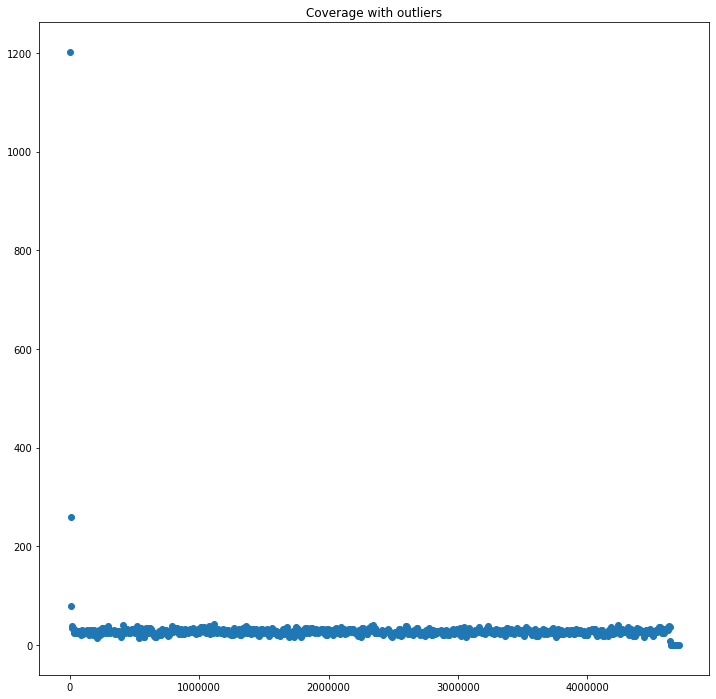

In [19]:
# покрытие с выбросами
per_base_coverage = get_coverage('alignment_ont.sam', 'reference.fasta')
n = len(per_base_coverage)
M = []
N = []
for i in range(0, n, 5000):
    M.append(i)
    N.append(sum(per_base_coverage[i:(i+5000)]) / 5000)
plt.figure(figsize=(12, 12))
plt.title('Coverage with outliers')
plt.scatter(M, N)

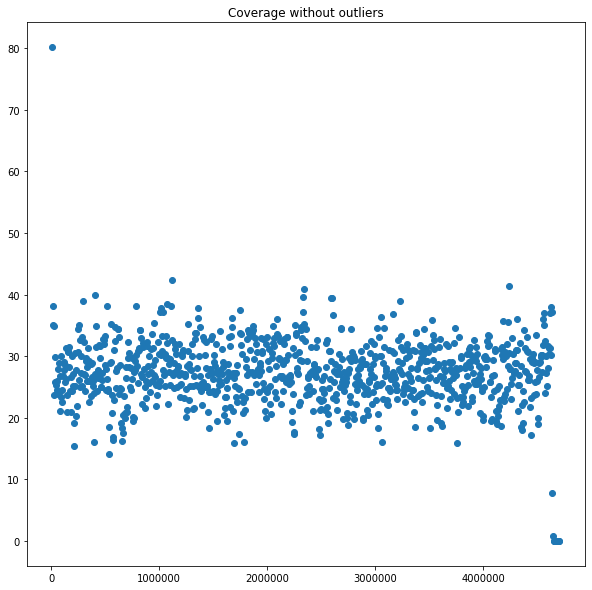

In [20]:
# покрытие без выбросов
N = np.asarray(N)
indices = np.argwhere(N < 200).flatten()
N_ = [N[i] for i in range(len(N)) if i in indices]
M_ = [M[i] for i in range(len(M)) if i in indices]
plt.figure(figsize=(10, 10))
plt.title('Coverage without outliers')
plt.scatter(M_, N_)

In [21]:
print(f'Среднее покрытие: {int(sum(per_base_coverage) / len(per_base_coverage))}')
count_covered_bases = 0
for base in per_base_coverage:
    if base != 0:
        count_covered_bases += 1
print(f'Процент покрытия: {(count_covered_bases / n) * 100} %')

Среднее покрытие: 28
Процент покрытия: 98.79550535629629 %


Сравним с данными из bbmap:

In [22]:
! /Users/olga/Downloads/bbmap/pileup.sh in=alignment_ont.sam out=bbmap_ont.txt hist=hist_ont.txt

/Users/olga/Downloads/bbmap//calcmem.sh: line 75: [: -v: unary operator expected
Max memory cannot be determined.  Attempting to use 3200 MB.
If this fails, please add the -Xmx flag (e.g. -Xmx24g) to your command, 
or run this program qsubbed or from a qlogin session on Genepool, or set ulimit to an appropriate value.
java -ea -Xmx3200m -cp /Users/olga/Downloads/bbmap/current/ jgi.CoveragePileup in=alignment_ont.sam out=bbmap_ont.txt hist=hist_ont.txt
Executing jgi.CoveragePileup [in=alignment_ont.sam, out=bbmap_ont.txt, hist=hist_ont.txt]

Reads:                               	32103
Mapped reads:                        	29565
Mapped bases:                        	125216746
Ref scaffolds:                       	1
Ref bases:                           	4639675

Percent mapped:                      	92.094
Percent proper pairs:                	0.000
Average coverage:                    	26.988
Average coverage with deletions:     	28.341
Standard deviation:                    	6.312
Perce

При сравнении результатов покрытия генома выяснилось, что у ридов Oxford Nanopores и Pacbio почти совпадает процент покрытия генома. Среднее покрытие различается (у Oxford Nanopores оно равно 28, тогда как у Pacbio оно равно 48). Также различаются графики покрытий - как с выбросами, так и без них: значения выбросов по количеству ридов у Oxford Nanopores выше (около 250 и 1200 по сравнению со значениями 100 и примерно 300 для Pacbio), дисперсия распределения покрытия выше у ридов Pacbio. Сравнивая данные результаты с результатами bbmap, выяснилось, что процент покрытия почти совпадает для ридов обоих типов, среднее покрытие ридов Oxford Nanopores также практически сопадает, а среднее покрытие ридов Pacbio несколько различается.

#### Таблица частот замен / вставок / удалений + средний процент ошибок в ридах

In [26]:
def get_errors(sam_file_name, ref_file_name):
    errors = {('A', 'A'): 0, ('A', 'C'): 0, ('A', 'G'): 0, ('A', 'T'): 0, ('A', '-'): 0, 
              ('C', 'A'): 0, ('C', 'C'): 0, ('C', 'G'): 0, ('C', 'T'): 0, ('C', '-'): 0,
              ('G', 'A'): 0, ('G', 'C'): 0, ('G', 'G'): 0, ('G', 'T'): 0, ('G', '-'): 0, 
              ('T', 'A'): 0, ('T', 'C'): 0, ('T', 'G'): 0, ('T', 'T'): 0, ('T', '-'): 0,
              ('-', 'A'): 0, ('-', 'C'): 0, ('-', 'G'): 0, ('-', 'T'): 0, ('-', '-'): 0}
    sam_file = open(sam_file_name, 'r')
    ref_file = open(ref_file_name, 'r')
    sam_file.readline()
    sam_file.readline()
    ref_file.readline()
    ref_seq = ''
    ref_length = 0
    for line in ref_file:
        ref_seq += line.strip()
    ref_file.close()
    ref_length = len(ref_seq)
    total_align_info = {}
    for line in sam_file:
        line = line.strip().split()
        if line[5] == '*':
                continue
        start = int(line[3])
        read_length = len(line[9])
        read_seq = line[9]
        stop = min(start + read_length - 1, ref_length)
        align_info = list(Cigar(line[5]).items())
        for (num, letter) in align_info:
            if letter not in total_align_info.keys():
                total_align_info[letter] = num
            else:
                total_align_info[letter] += num
        align_info_string = ''.join([letter*num for (num, letter) in align_info])
        for i in range(start - 1, stop):
            if (read_seq[i - start + 1], ref_seq[i]) == ('A', 'C') and align_info_string[i - start + 1] == 'M':
                errors[('A', 'C')] += 1
            elif (read_seq[i - start + 1], ref_seq[i]) == ('A', 'G') and align_info_string[i - start + 1] == 'M':
                errors[('A', 'G')] += 1
            elif (read_seq[i - start + 1], ref_seq[i]) == ('A', 'T') and align_info_string[i - start + 1] == 'M':
                errors[('A', 'T')] += 1
            elif (read_seq[i - start + 1], ref_seq[i]) == ('C', 'A') and align_info_string[i - start + 1] == 'M':
                errors[('C', 'A')] += 1
            elif (read_seq[i - start + 1], ref_seq[i]) == ('C', 'G') and align_info_string[i - start + 1] == 'M':
                errors[('C', 'G')] += 1
            elif (read_seq[i - start + 1], ref_seq[i]) == ('C', 'T') and align_info_string[i - start + 1] == 'M':
                errors[('C', 'T')] += 1
            elif (read_seq[i - start + 1], ref_seq[i]) == ('G', 'A') and align_info_string[i - start + 1] == 'M':
                errors[('G', 'A')] += 1
            elif (read_seq[i - start + 1], ref_seq[i]) == ('G', 'C') and align_info_string[i - start + 1] == 'M':
                errors[('G', 'C')] += 1
            elif (read_seq[i - start + 1], ref_seq[i]) == ('G', 'T') and align_info_string[i - start + 1] == 'M':
                errors[('G', 'T')] += 1
            elif (read_seq[i - start + 1], ref_seq[i]) == ('T', 'A') and align_info_string[i - start + 1] == 'M':
                errors[('T', 'A')] += 1
            elif (read_seq[i - start + 1], ref_seq[i]) == ('T', 'C') and align_info_string[i - start + 1] == 'M':
                errors[('T', 'C')] += 1
            elif (read_seq[i - start + 1], ref_seq[i]) == ('T', 'G') and align_info_string[i - start + 1] == 'M':
                errors[('T', 'G')] += 1
            elif ref_seq[i] == 'A' and align_info_string[i - start + 1] == 'I':
                errors[('A', '-')] += 1
            elif ref_seq[i] == 'C' and align_info_string[i - start + 1] == 'I':
                errors[('C', '-')] += 1
            elif ref_seq[i] == 'G' and align_info_string[i - start + 1] == 'I':
                errors[('G', '-')] += 1
            elif ref_seq[i] == 'T' and align_info_string[i - start + 1] == 'I':
                errors[('T', '-')] += 1
            elif ref_seq[i] == 'A' and align_info_string[i - start + 1] == 'D':
                errors[('-', 'A')] += 1
            elif ref_seq[i] == 'C' and align_info_string[i - start + 1] == 'D':
                errors[('-', 'C')] += 1
            elif ref_seq[i] == 'G' and align_info_string[i - start + 1] == 'D':
                errors[('-', 'G')] += 1
            elif ref_seq[i] == 'T' and align_info_string[i - start + 1] == 'D':
                errors[('-', 'T')] += 1
    sam_file.close()
    total_len = np.sum(list(total_align_info.values()))
    return errors, total_len

Риды Pacbio

In [27]:
errors, total_len = get_errors('alignment_pacbio.sam', 'reference.fasta')
print('Матрица замен / инделов:')
errors_df = pd.DataFrame(np.array(list(errors.values())).reshape(5, 5), columns=['A', 'C', 'G', 'T', '-'], index=['A', 'C', 'G', 'T', '-'])
print(errors_df)
print('------------------------------')
print('Матрица частот замен / инделов:')
errors_freq_arr = np.array(list(errors.values())) / total_len
errors_freq_df = pd.DataFrame(errors_freq_arr.reshape(5, 5), columns=['A', 'C', 'G', 'T', '-'], index=['A', 'C', 'G', 'T', '-'])
print(errors_freq_df)

Матрица замен / инделов:
          A         C         G         T        -
A         0  10397962  10339510  10258751  3773825
C  10390705         0  10763160  10350389  3844765
G  10349003  10754825         0  10352755  3833697
T  10254923  10370254  10343156         0  3759566
-   1633095   1674497   1669399   1631851        0
------------------------------
Матрица частот замен / инделов:
          A         C         G         T         -
A  0.000000  0.036752  0.036545  0.036260  0.013339
C  0.036726  0.000000  0.038043  0.036584  0.013590
G  0.036579  0.038013  0.000000  0.036592  0.013550
T  0.036247  0.036654  0.036558  0.000000  0.013288
-  0.005772  0.005919  0.005901  0.005768  0.000000


In [28]:
print(f'Средний процент ошибок в ридах: {np.mean([errors[elem]/total_len for elem in errors.keys()]) * 100} %') # средний процент ошибок в ридах

Средний процент ошибок в ридах: 2.0747236410344563 %


Риды Oxford Nanopores

In [29]:
errors, total_len = get_errors('alignment_ont.sam', 'reference.fasta')
print('Матрица замен / инделов:')
errors_df = pd.DataFrame(np.array(list(errors.values())).reshape(5, 5), columns=['A', 'C', 'G', 'T', '-'], index=['A', 'C', 'G', 'T', '-'])
print(errors_df)
print('------------------------------')
print('Матрица частот замен / инделов:')
errors_freq_arr = np.array(list(errors.values())) / total_len
errors_freq_df = pd.DataFrame(errors_freq_arr.reshape(5, 5), columns=['A', 'C', 'G', 'T', '-'], index=['A', 'C', 'G', 'T', '-'])
print(errors_freq_df)

Матрица замен / инделов:
         A        C        G        T       -
A        0  7268063  7241246  7102618  362456
C  7288936        0  7664235  7276923  373382
G  7268228  7669100        0  7275899  371931
T  7117549  7264717  7266043        0  361884
-  1460162  1513870  1511163  1458533       0
------------------------------
Матрица частот замен / инделов:
          A         C         G         T         -
A  0.000000  0.052480  0.052286  0.051285  0.002617
C  0.052631  0.000000  0.055341  0.052544  0.002696
G  0.052481  0.055376  0.000000  0.052537  0.002686
T  0.051393  0.052456  0.052465  0.000000  0.002613
-  0.010543  0.010931  0.010912  0.010532  0.000000


In [30]:
print(f'Средний процент ошибок в ридах: {np.mean([errors[elem]/total_len for elem in errors.keys()]) * 100} %') # средний процент ошибок в ридах

Средний процент ошибок в ридах: 2.7472187413948084 %


Средний процент ошибок в ридах Oxford Nanopores несколько выше, чем у ридов Pacbio. Части матриц частот замен у ридов обоих типов почти симметричны, причём у ридов Oxford Nanopores ошибки замен происходят чаще (приблизительно 0.035 и 0.052 соответственно). Что касается вставок / удалений, то у ридов обоих типов удаления происходят чаще, вставки / удаления распределены почти равномерно по нуклеотидам. 

#### Распределение длин инделов

In [31]:
def get_indel_lengths(sam_file_name):
    sam_file = open(sam_file_name, 'r')
    sam_file.readline()
    sam_file.readline()
    insertion_lengths = {}
    deletion_lengths = {}
    indel_lengths = {}
    for line in sam_file:
        line = line.strip().split()
        if line[5] == '*':
            continue
        align_info = list(Cigar(line[5]).items())
        for (num, letter) in align_info:
            if letter == 'D':
                if num not in deletion_lengths.keys():
                    deletion_lengths[num] = 1
                else:
                    deletion_lengths[num] += 1
                if num not in indel_lengths.keys():
                    indel_lengths[num] = 1
                else:
                    indel_lengths[num] += 1
            elif letter == 'I':
                if num not in insertion_lengths.keys():
                    insertion_lengths[num] = 1
                else:
                    insertion_lengths[num] += 1
                if num not in indel_lengths.keys():
                    indel_lengths[num] = 1
                else:
                    indel_lengths[num] += 1
    sam_file.close()
    return deletion_lengths, insertion_lengths, indel_lengths

Риды Pacbio (графики построены в логарифмической шкале)

Медианная длина делеций: 76.0
Минимальная длина делеций: 1
Максимальная длина делеций: 1900


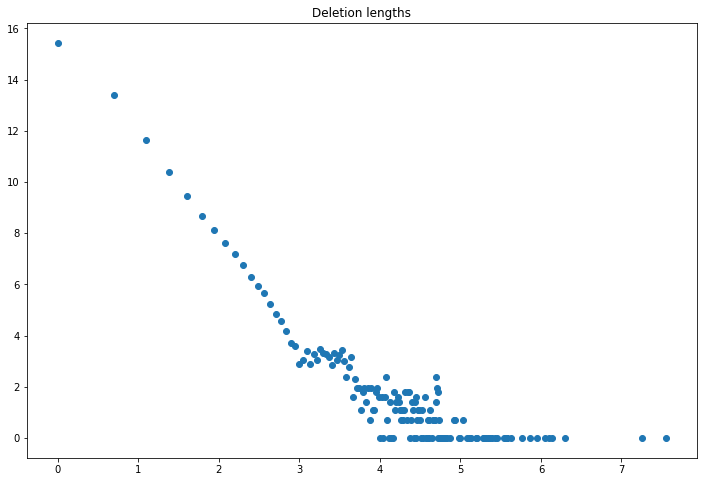

In [35]:
deletion_lengths, insertion_lengths, indel_lengths = get_indel_lengths('alignment_pacbio.sam')
print(f'Медианная длина делеций: {np.median(list(deletion_lengths.keys()))}')
print(f'Минимальная длина делеций: {min(list(deletion_lengths.keys()))}')
print(f'Максимальная длина делеций: {max(list(deletion_lengths.keys()))}')

n = len(list(deletion_lengths.keys()))
M = []
N = []
for elem in deletion_lengths.keys():
    M.append(np.log(elem))
    N.append(np.log(deletion_lengths[elem]))

plt.figure(figsize=(12, 8))
plt.title('Deletion lengths')
plt.scatter(M, N)

Медианная длина вставок: 220.5
Минимальная длина вставок: 1
Максимальная длина вставок: 2798


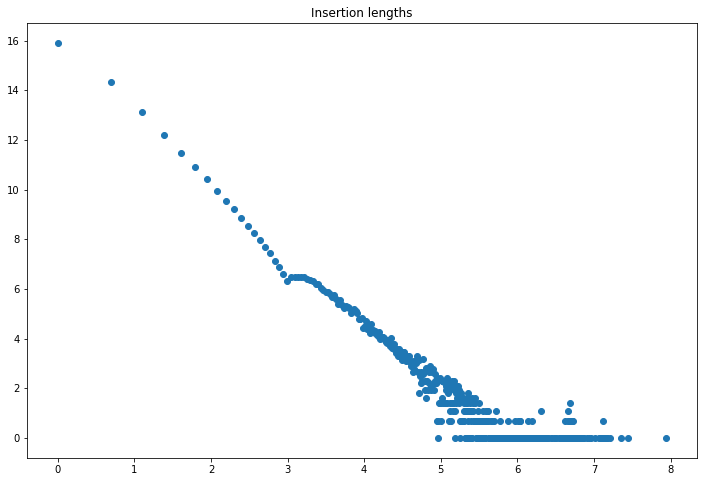

In [36]:
print(f'Медианная длина вставок: {np.median(list(insertion_lengths.keys()))}')
print(f'Минимальная длина вставок: {min(list(insertion_lengths.keys()))}')
print(f'Максимальная длина вставок: {max(list(insertion_lengths.keys()))}')

n = len(list(insertion_lengths.keys()))
M = []
N = []
for elem in insertion_lengths.keys():
    M.append(np.log(elem))
    N.append(np.log(insertion_lengths[elem]))

plt.figure(figsize=(12, 8))
plt.title('Insertion lengths')
plt.scatter(M, N)

Медианная длина инделов: 228.0
Минимальная длина инделов: 1
Максимальная длина инделов: 2798


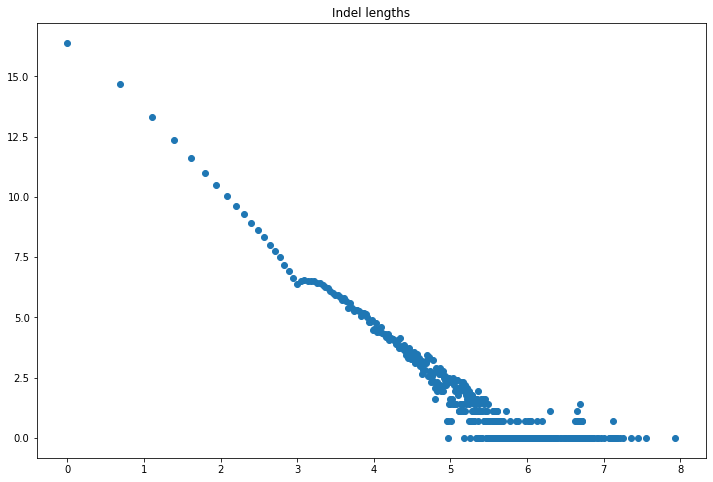

In [37]:
print(f'Медианная длина инделов: {np.median(list(indel_lengths.keys()))}')
print(f'Минимальная длина инделов: {min(list(indel_lengths.keys()))}')
print(f'Максимальная длина инделов: {max(list(indel_lengths.keys()))}')

n = len(list(indel_lengths.keys()))
M = []
N = []
for elem in indel_lengths.keys():
    M.append(np.log(elem))
    N.append(np.log(indel_lengths[elem]))

plt.figure(figsize=(12, 8))
plt.title('Indel lengths')
plt.scatter(M, N)

Риды Oxford Nanopores

Медианная длина делеций: 77.0
Минимальная длина делеций: 1
Максимальная длина делеций: 798


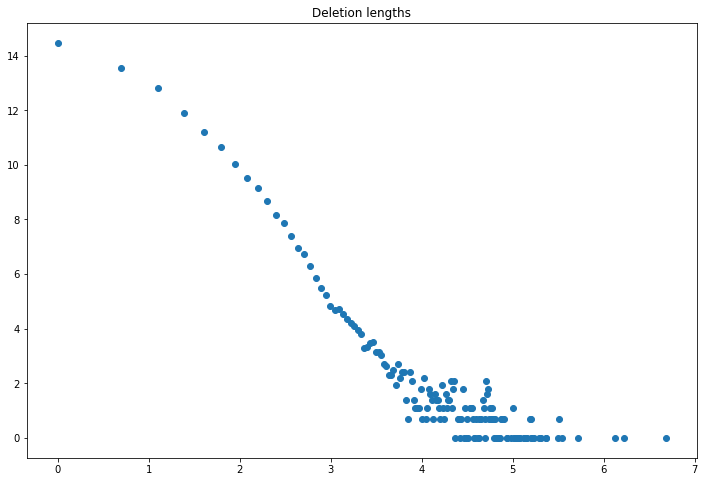

In [38]:
deletion_lengths, insertion_lengths, indel_lengths = get_indel_lengths('alignment_ont.sam')
print(f'Медианная длина делеций: {np.median(list(deletion_lengths.keys()))}')
print(f'Минимальная длина делеций: {min(list(deletion_lengths.keys()))}')
print(f'Максимальная длина делеций: {max(list(deletion_lengths.keys()))}')

n = len(list(deletion_lengths.keys()))
M = []
N = []
for elem in deletion_lengths.keys():
    M.append(np.log(elem))
    N.append(np.log(deletion_lengths[elem]))

plt.figure(figsize=(12, 8))
plt.title('Deletion lengths')
plt.scatter(M, N)

Медианная длина вставок: 139.0
Минимальная длина вставок: 1
Максимальная длина вставок: 1196


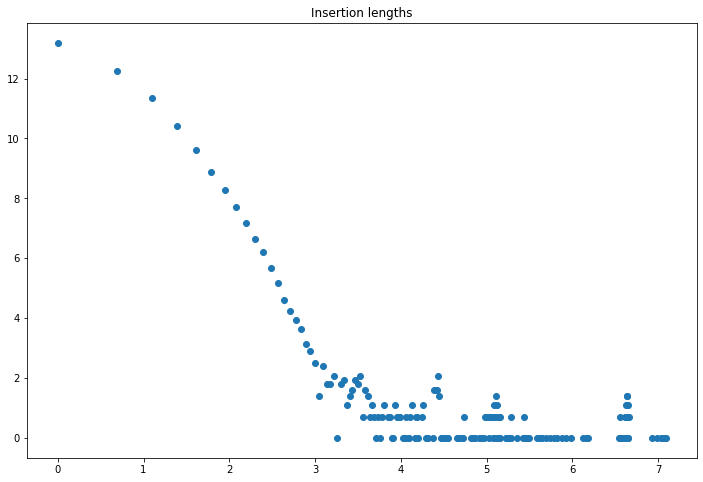

In [39]:
print(f'Медианная длина вставок: {np.median(list(insertion_lengths.keys()))}')
print(f'Минимальная длина вставок: {min(list(insertion_lengths.keys()))}')
print(f'Максимальная длина вставок: {max(list(insertion_lengths.keys()))}')

n = len(list(insertion_lengths.keys()))
M = []
N = []
for elem in insertion_lengths.keys():
    M.append(np.log(elem))
    N.append(np.log(insertion_lengths[elem]))

plt.figure(figsize=(12, 8))
plt.title('Insertion lengths')
plt.scatter(M, N)

Медианная длина инделов: 126.0
Минимальная длина инделов: 1
Максимальная длина инделов: 1196


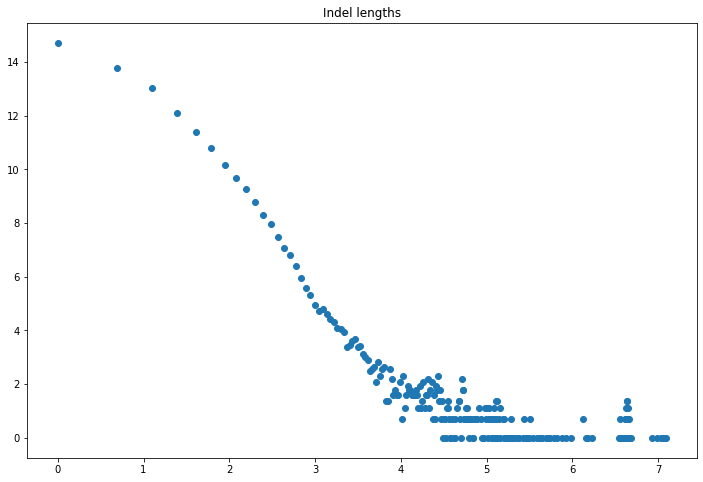

In [40]:
print(f'Медианная длина инделов: {np.median(list(indel_lengths.keys()))}')
print(f'Минимальная длина инделов: {min(list(indel_lengths.keys()))}')
print(f'Максимальная длина инделов: {max(list(indel_lengths.keys()))}')

n = len(list(indel_lengths.keys()))
M = []
N = []
for elem in indel_lengths.keys():
    M.append(np.log(elem))
    N.append(np.log(indel_lengths[elem]))

plt.figure(figsize=(12, 8))
plt.title('Indel lengths')
plt.scatter(M, N)

У ридов Pacbio распределение длин делеций варьируется в большем диапазоне (до 1900 bp), чем у ридов Oxford Nanopore (до 798 bp), но медианная длина делеций у ридов обоих типов практически одинакова. То же верно и для распределения длин вставок: у ридов Pacbio распределение длин вставок варьируется от 1 до 2798 bp, тогда как у ридов Oxford Nanopores - от 1 до 1196 bp. Медианная длина вставок у Pacbio выше. Скетчи графиков распределений длин делеций / вставок / инделов в целом практически одинаковы. 